## Rerun - Offer Analysis - Individual vs. Shared Type
[Analytics ticket here](https://banksimple.atlassian.net/browse/AL-981)

In [1]:
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import date
from simply import redshift
from pandas import DataFrame
from matplotlib import pyplot as plt

### Population:
- Every account paid out for the offer. 
- Broken between shared vs. indie type
- 1 row with balance for each day post hold by deadline

In [4]:
account_retention = redshift("""
with min_enrollment_date as ( --for each account that was paid out, what was the first enrollment date for shared partners
select distinct
    fua.account_ref,
    min(du.first_account_open_date) as min_first_account_open_date
from fact_offer_account foa
join fact_user_account fua on foa.account_ref = fua.account_ref --joins back to grab partner B
join dim_user du on fua.user_ref = du.user_ref
where paid_out = true
group by 1
    ),

balance_hold_by_deadline as (
select
    foa.account_ref,
    offer_month,
    foa.type,
    case when offer_month = '2019-07-01' then '2019-10-31'::date else '2019-12-31'::date end as hold_by_date,
    ledger_balance_eod as hold_by_balance,
    da.close_date
from fact_offer_account foa
join fact_account_day fad on foa.account_ref = fad.account_ref
join dim_account da on fad.account_ref = da.account_ref
join min_enrollment_date med on foa.account_ref = med.account_ref
where offer_month in ('2019-07-01','2019-08-01','2019-09-01')
    and fad.date = hold_by_date
    and foa.type ilike '%PROTECTED'
    and paid_out = true
    and min_first_account_open_date >= '2019-07-01'
    ),

post_hold_deadline as (
select
    foa.account_ref,
    foa.offer_month,
    case when foa.offer_month = '2019-07-01' then '2019-10-31'::date else '2019-12-31'::date end as hold_by_date,
    hold_by_balance,
    foa.type,
    date,
    datediff(day,hold_by_date,date) as days_since_hold_deadline,
    payout_amount,
    ledger_balance_eod as ledger_balance_eod,
    case when 10000 <= ledger_balance_eod then 1 else 0 end maintained_balance_flag,
    (ledger_balance_eod - hold_by_balance) as balance_diff,
    (ledger_balance_eod/hold_by_balance -1) as percent_change_in_balance
from fact_offer_account foa
join balance_hold_by_deadline b on foa.account_ref = b.account_ref
join fact_account_day fad on foa.account_ref = fad.account_ref
where foa.offer_month in ('2019-07-01','2019-08-01','2019-09-01')
    and fad.date >= hold_by_date
    and fad.date < current_date
    and foa.type ilike '%PROTECTED'
    and paid_out = true --only look at folks who were paid out
    and days_since_hold_deadline = 200 --originally 60
    )

select
    b.account_ref,
    b.hold_by_date,
    close_date,
    b.offer_month,
    b.hold_by_balance,
    b.type,
    date,
    isnull(days_since_hold_deadline,200) as days_since_hold_deadline, --originally 60
    payout_amount,
    isnull(ledger_balance_eod,0) as ledger_balance_eod,
    isnull(maintained_balance_flag,0) as maintained_balance_flag,
    isnull(balance_diff,(b.hold_by_balance*-1)) as balance_diff,
    percent_change_in_balance
from balance_hold_by_deadline b
left join post_hold_deadline as p on b.account_ref = p.account_ref
;
""")

In [5]:
account_retention.describe()

,hold_by_balance,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff,percent_change_in_balance
count,4258.000000,4258.0,2857.000000,4258.000000,4258.000000,4258.000000,2857.000000
mean,13304.021101,200.0,234.774239,5472.807062,0.228981,-7831.214039,-0.454203
std,15640.809537,0.0,35.933331,16970.389719,0.420226,17600.486193,1.264319
min,0.010000,200.0,150.000000,0.000000,0.000000,-380064.840000,-1.000000
25%,10036.780000,200.0,250.000000,0.000000,0.000000,-10061.080000,-0.999958
50%,10054.610000,200.0,250.000000,0.490000,0.000000,-10037.185000,-0.998746
75%,10138.805000,200.0,250.000000,4612.797500,0.000000,-9413.637500,0.034530
max,380064.840000,200.0,250.000000,344802.540000,1.000000,294374.480000,29.348932


In [6]:
account_retention.head()

,account_ref,hold_by_date,close_date,offer_month,hold_by_balance,type,date,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff,percent_change_in_balance
0,0b872b89-a5de-3574-b869-ea7ce3331ad0,2019-12-31,None,2019-08-01,11966.58,INDIVIDUAL_PROTECTED,2020-07-18,200,250.0,10216.29,1,-1750.29,-0.146265
1,15aa7370-ad3d-382a-9a89-e48f8e5859ed,2019-12-31,None,2019-08-01,10115.77,INDIVIDUAL_PROTECTED,2020-07-18,200,250.0,0.00,0,-10115.77,-1.000000
2,2c86bbbf-d2c8-3e11-81af-b33bb19f6184,2019-10-31,None,2019-07-01,10040.15,INDIVIDUAL_PROTECTED,2020-05-18,200,250.0,2.35,0,-10037.80,-0.999766
3,3ad3b791-874e-32a7-a1f8-8b4b16a8fb00,2019-10-31,None,2019-07-01,10087.72,INDIVIDUAL_PROTECTED,2020-05-18,200,250.0,4.92,0,-10082.80,-0.999512
4,4b92e611-a7d4-3470-b965-26639e2f6d2b,2019-12-31,None,2019-08-01,10063.15,SHARED_PROTECTED,2020-07-18,200,250.0,10412.78,1,349.63,0.034744


In [7]:
#Currently it has been 60 days since the hold deadline for August and September. Use day 60 for balance retention

retention_day_200 = account_retention[account_retention.days_since_hold_deadline == 200]

#yesterday_retention = account_retention[account_retention.date == date(2020, 3, 1)]
#type('2020-03-01')
#type(account_retention.date[0])
#account_level_retention.date
#type(account_level_retention.date)

In [8]:
retention_day_200.head()

,account_ref,hold_by_date,close_date,offer_month,hold_by_balance,type,date,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff,percent_change_in_balance
0,0b872b89-a5de-3574-b869-ea7ce3331ad0,2019-12-31,None,2019-08-01,11966.58,INDIVIDUAL_PROTECTED,2020-07-18,200,250.0,10216.29,1,-1750.29,-0.146265
1,15aa7370-ad3d-382a-9a89-e48f8e5859ed,2019-12-31,None,2019-08-01,10115.77,INDIVIDUAL_PROTECTED,2020-07-18,200,250.0,0.00,0,-10115.77,-1.000000
2,2c86bbbf-d2c8-3e11-81af-b33bb19f6184,2019-10-31,None,2019-07-01,10040.15,INDIVIDUAL_PROTECTED,2020-05-18,200,250.0,2.35,0,-10037.80,-0.999766
3,3ad3b791-874e-32a7-a1f8-8b4b16a8fb00,2019-10-31,None,2019-07-01,10087.72,INDIVIDUAL_PROTECTED,2020-05-18,200,250.0,4.92,0,-10082.80,-0.999512
4,4b92e611-a7d4-3470-b965-26639e2f6d2b,2019-12-31,None,2019-08-01,10063.15,SHARED_PROTECTED,2020-07-18,200,250.0,10412.78,1,349.63,0.034744


In [9]:
retention_day_200.groupby(['type']).mean().reset_index()
#Rate at which accounts still have a balance of $10,000 on day 60 by type

,type,hold_by_balance,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff,percent_change_in_balance
0,INDIVIDUAL_PROTECTED,13475.279304,200.0,234.921292,5396.078523,0.233164,-8079.200781,-0.485350
1,SHARED_PROTECTED,12468.072914,200.0,233.972912,5847.335594,0.208564,-6620.737320,-0.284475


In [10]:
account_counts_day_200 = retention_day_200[['type','offer_month','account_ref','balance_diff']].groupby(['type','offer_month']).count().reset_index()
account_counts_day_200

,type,offer_month,account_ref,balance_diff
0,INDIVIDUAL_PROTECTED,2019-07-01,1546,1546
1,INDIVIDUAL_PROTECTED,2019-08-01,1508,1508
2,INDIVIDUAL_PROTECTED,2019-09-01,480,480
3,SHARED_PROTECTED,2019-07-01,324,324
4,SHARED_PROTECTED,2019-08-01,304,304
5,SHARED_PROTECTED,2019-09-01,96,96


In [11]:
account_maintain_balance_day_200 = retention_day_200[['type','offer_month','maintained_balance_flag','balance_diff']].groupby(['type','offer_month']).mean().reset_index()
#Rate at which accounts still have a balance of $10,000 on day 60 by type and offer month

In [12]:
maintain_balance_rate = account_maintain_balance_day_200.join(account_counts_day_200[['account_ref']], lsuffix='_caller', rsuffix='_other')
maintain_balance_rate
#Note the reason we need to call the 'account_ref' is because that is the only column we need to pull in to join. Otherwise we end up with repeat columns

,type,offer_month,maintained_balance_flag,balance_diff,account_ref
0,INDIVIDUAL_PROTECTED,2019-07-01,0.201164,-7241.368984,1546
1,INDIVIDUAL_PROTECTED,2019-08-01,0.232759,-9158.755537,1508
2,INDIVIDUAL_PROTECTED,2019-09-01,0.337500,-7386.116167,480
3,SHARED_PROTECTED,2019-07-01,0.185185,-6243.535370,324
4,SHARED_PROTECTED,2019-08-01,0.187500,-8281.568125,304
5,SHARED_PROTECTED,2019-09-01,0.354167,-2634.496354,96


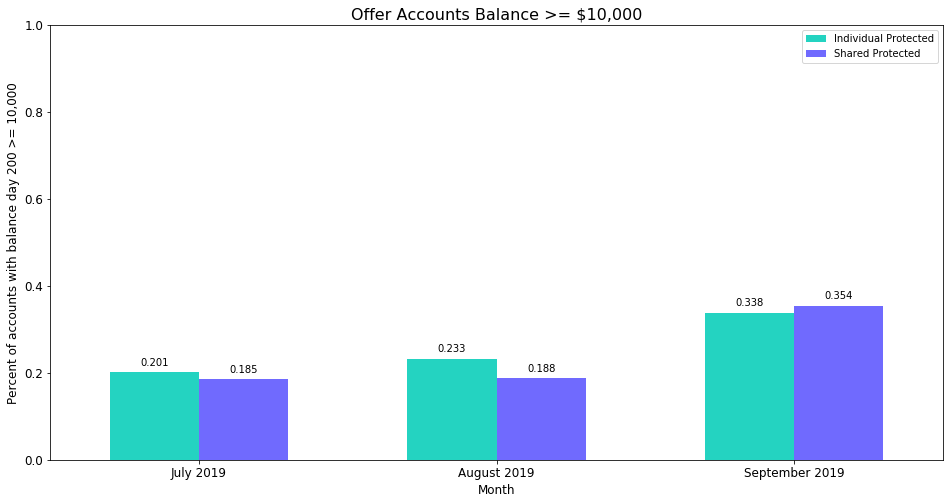

In [13]:
fig, ax = plt.subplots(figsize=(16,8))

indie = maintain_balance_rate[maintain_balance_rate.type == 'INDIVIDUAL_PROTECTED']
shared = maintain_balance_rate[maintain_balance_rate.type == 'SHARED_PROTECTED']

month1 = indie.index
month2 = shared.index

labels = ['July 2019','August 2019','September 2019']

width = 0.30
ax.set_xticks(indie.index)
ax.set_xticklabels(labels)

p1 = plt.bar(month1-width/2, indie.maintained_balance_flag, width, color = '#24D3C1')
p2 = plt.bar(month2-(3-width/2), shared.maintained_balance_flag, width, color = '#706AFE')
#p2 = plt.bar(month2-2.85, shared.maintained_balance_flag, width, color = '#706AFE')

plt.xlim(-0.5,2.5)
plt.ylim(0,1)
plt.xlabel('Month', fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('Percent of accounts with balance day 200 >= 10,000', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Offer Accounts Balance >= $10,000', fontsize = 16)
plt.legend(['Individual Protected','Shared Protected'], fontsize=10)
plt.grid(False)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    textcoords="offset points",
                    xytext=(0,5),
                    ha='center', va='bottom')

autolabel(p1)
autolabel(p2)

#plt.axvline(p1_x_value)

plt.show()

In [14]:
p1_x_value = p1[0].get_x()

In [15]:
for b in p1:
    print(b)

Rectangle(xy=(-0.3, 0), width=0.3, height=0.201164, angle=0)
Rectangle(xy=(0.7, 0), width=0.3, height=0.232759, angle=0)
Rectangle(xy=(1.7, 0), width=0.3, height=0.3375, angle=0)


In [16]:
s = 'one two three {}'

In [17]:
'one two three {}'.format('four')

'one two three four'

In [18]:
s.format('four')

'one two three four'

In [19]:
str(round(p1[0].get_height(),3))

'0.201'

In [20]:
'{}'.format(p1[0].get_height())

'0.20116429495472185'

#### Ignore the next 6 lines as they were just for practice
-----------

In [21]:
#account_maintain_balance.join(account_counts.set_index(['type','offer_month']), on=['type','offer_month'], lsuffix='_caller', rsuffix='_other')


In [22]:
#help(account_maintain_balance.join)

In [23]:
a = 'string'

In [24]:
a.split

<function str.split(sep=None, maxsplit=-1)>

In [25]:
a.split()

['string']

In [26]:
#help(a.split())

------
#### Resume Analysis

In [27]:
retention_day_200.reset_index().head()

,index,account_ref,hold_by_date,close_date,offer_month,hold_by_balance,type,date,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff,percent_change_in_balance
0,0,0b872b89-a5de-3574-b869-ea7ce3331ad0,2019-12-31,None,2019-08-01,11966.58,INDIVIDUAL_PROTECTED,2020-07-18,200,250.0,10216.29,1,-1750.29,-0.146265
1,1,15aa7370-ad3d-382a-9a89-e48f8e5859ed,2019-12-31,None,2019-08-01,10115.77,INDIVIDUAL_PROTECTED,2020-07-18,200,250.0,0.00,0,-10115.77,-1.000000
2,2,2c86bbbf-d2c8-3e11-81af-b33bb19f6184,2019-10-31,None,2019-07-01,10040.15,INDIVIDUAL_PROTECTED,2020-05-18,200,250.0,2.35,0,-10037.80,-0.999766
3,3,3ad3b791-874e-32a7-a1f8-8b4b16a8fb00,2019-10-31,None,2019-07-01,10087.72,INDIVIDUAL_PROTECTED,2020-05-18,200,250.0,4.92,0,-10082.80,-0.999512
4,4,4b92e611-a7d4-3470-b965-26639e2f6d2b,2019-12-31,None,2019-08-01,10063.15,SHARED_PROTECTED,2020-07-18,200,250.0,10412.78,1,349.63,0.034744


### Chi Square Test
Measure the difference between individual vs. shared accounts to determine if their balance is still >= $10,000

In [28]:
individual_retention_day_200 = retention_day_200[retention_day_200.type =='INDIVIDUAL_PROTECTED']
shared_retention_day_200 = retention_day_200[retention_day_200.type =='SHARED_PROTECTED']

obs = np.array([[individual_retention_day_200[individual_retention_day_200.maintained_balance_flag == 1].account_ref.count(),individual_retention_day_200[individual_retention_day_200.maintained_balance_flag == 0].account_ref.count()],
               [shared_retention_day_200[shared_retention_day_200.maintained_balance_flag == 1].account_ref.count(),shared_retention_day_200[shared_retention_day_200.maintained_balance_flag == 0].account_ref.count()]])
chi2, p, dof, expected = stats.chi2_contingency(obs)

print(p)

# obs = np.array([
#                 [10, 10, 20], 
#                 [20, 20, 20]
#                 ])
#chi2_contingency(obs)

0.16555621306436538


In [29]:
#help(np.array)

### Understand difference between balance between hold deadline to day 60
Get the difference between day 0 and day 60 of balances. Then run a t-test on that difference

In [30]:
shared_retention_day_200.describe()

,hold_by_balance,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff,percent_change_in_balance
count,724.000000,724.0,443.000000,724.000000,724.000000,724.000000,443.000000
mean,12468.072914,200.0,233.972912,5847.335594,0.208564,-6620.737320,-0.284475
std,12918.889461,0.0,36.727185,21312.192691,0.406563,20622.371846,2.143447
min,0.010000,200.0,150.000000,0.000000,0.000000,-141545.530000,-1.000000
25%,10034.560000,200.0,250.000000,0.000000,0.000000,-10055.465000,-0.999999
50%,10049.380000,200.0,250.000000,0.000000,0.000000,-10035.375000,-0.998937
75%,10068.650000,200.0,250.000000,401.237500,0.000000,-9699.555000,0.034745
max,228500.000000,200.0,250.000000,304404.640000,1.000000,294374.480000,29.348932


In [31]:
individual_retention_day_200.describe()

,hold_by_balance,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff,percent_change_in_balance
count,3534.000000,3534.0,2414.000000,3534.000000,3534.000000,3534.000000,2414.000000
mean,13475.279304,200.0,234.921292,5396.078523,0.233164,-8079.200781,-0.485350
std,16138.151081,0.0,35.791535,15938.204394,0.422905,16907.567046,1.021832
min,0.740000,200.0,150.000000,0.000000,0.000000,-380064.840000,-1.000000
25%,10037.300000,200.0,250.000000,0.000000,0.000000,-10062.217500,-0.999951
50%,10055.430000,200.0,250.000000,0.820000,0.000000,-10037.300000,-0.998676
75%,10151.095000,200.0,250.000000,5100.025000,0.000000,-8653.852500,0.034518
max,380064.840000,200.0,250.000000,344802.540000,1.000000,217267.090000,19.661593


### T Test - Determine difference in balance change

In [32]:
tt = stats.ttest_ind(individual_retention_day_200.balance_diff, shared_retention_day_200.balance_diff, nan_policy='omit')

In [33]:
tt.pvalue

0.04221257548100068

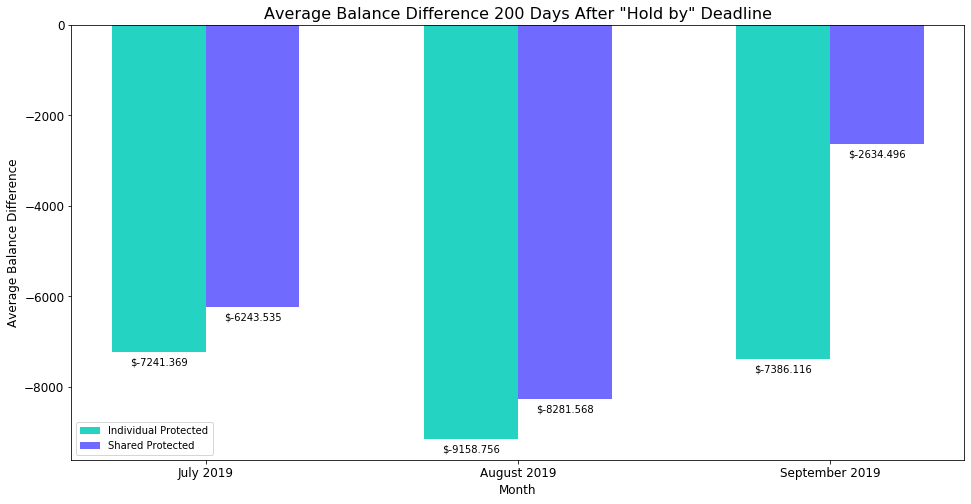

In [34]:
fig, ax = plt.subplots(figsize=(16,8))

indie = maintain_balance_rate[maintain_balance_rate.type == 'INDIVIDUAL_PROTECTED']
shared = maintain_balance_rate[maintain_balance_rate.type == 'SHARED_PROTECTED']

month1 = indie.index
month2 = shared.index

labels = ['July 2019','August 2019','September 2019']

width = 0.30
ax.set_xticks(indie.index)
ax.set_xticklabels(labels)

p1 = plt.bar(month1-width/2, indie.balance_diff, width, color = '#24D3C1')
p2 = plt.bar(month2-(3-width/2), shared.balance_diff, width, color = '#706AFE')
#p2 = plt.bar(month2-2.85, shared.maintained_balance_flag, width, color = '#706AFE')

#plt.xlim(-0.5,2.5)
#plt.ylim(0,1)
plt.xlabel('Month', fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('Average Balance Difference', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Average Balance Difference 200 Days After "Hold by" Deadline', fontsize = 16)
plt.legend(['Individual Protected','Shared Protected'], fontsize=10)
plt.grid(False)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('${}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    textcoords="offset points",
                    xytext=(0,-15),
                    ha='center', va='bottom')

autolabel(p1)
autolabel(p2)

#plt.axvline(p1_x_value)

plt.show()

## T Test to Determine Difference in Balance

In [35]:
tt_ledger_balance = stats.ttest_ind(individual_retention_day_200.ledger_balance_eod, shared_retention_day_200.ledger_balance_eod, nan_policy='omit')

In [36]:
tt_ledger_balance.pvalue

0.5145767894731217

In [37]:
tt_percent_change_in_balance = stats.ttest_ind(individual_retention_day_200.percent_change_in_balance, shared_retention_day_200.percent_change_in_balance, nan_policy='omit')
print(tt_percent_change_in_balance.pvalue)

0.0021007700022351535


## Plot to show the average balance and percent change in balance